In [ ]:
# import pandas as pd
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from Tools import hierarchical_contrastive_loss
# from Networks import TrEncoder
# from Evaluations import fit_svm
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import average_precision_score
# import copy
# from tqdm import tqdm

In [1]:
import numpy as np
import torch

from Dataprocessing import data_provider
from Tr2Vec import Tr2Vec

import time
import easydict

In [2]:
args = easydict.EasyDict({
    'model': 'C', # ['C', 'F'], C for Classification, F for Forecasting
    'path': './Data/3D/',
    'ratio': [7, 1, 2],
    'seq_len': 2656, # [2144, 4576, 2656] # 3200 in paper
    'pred_len': 100,
    'slice_len': 10, 
    'hidden_dims': 64,
    'repr_dims': 320,
    'slicing': False,
    'channel_num': 23,
    'class_num': 5,
    'layer_num': 10,
    'individual': True,
    'temporal_unit': 0,
    'num_workers': 8,
    'batch_size': 8,
    'lr': 0.001,
    'max_train_length': 3000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'debug': False,
})
    
if args.model == 'F':
    args.seq_len = 100

is_individual = 'indiv' if args.individual else 'joint'
checkpoint = f'./Checkpoint/{time.strftime('%Y-%m-%d', time.localtime(time.time()))}_E_{is_individual}_h{args.hidden_dims}_r{args.repr_dims}_l{args.layer_num}_in{args.seq_len}_ch{args.channel_num}.ckpt'
loadpoint = './Checkpoint/2024-05-31_E_indiv_h64_r320_l10_in2656_ch23.ckpt' # << 3000 iter (~ 13 epochs) trained model
# loadpoint = './Checkpoint/2024-06-02_E_indiv_h64_r320_l10_in2656_ch23.ckpt' # << 1 iter (~ under 1 epochs) trained model

In [3]:
trainset, trainloader = data_provider(args, 'train') # 'train', 'val', 'test'
testset, testloader = data_provider(args, 'test') # 'train', 'val', 'test'

tr2vec = Tr2Vec(args=args)
# tr2vec.train(trainset)
# tr2vec.save(checkpoint)
tr2vec.load(loadpoint)
out, eval_res = tr2vec.eval(trainset, testset)

print('Evaluation result:', eval_res)
# Evaluation result: {'acc': 0.996, 'auprc': 0.9989302325581395} for 3000 iter trained model
# Evaluation result: {'acc': 0.994, 'auprc': 0.9969543433382899} for 1 iter trained model

c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 66

Evaluation result: {'acc': 0.996, 'auprc': 0.998925925925926}


In [4]:
from Evaluations import fit_svm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

train_repr = tr2vec.encode(trainset.data_x)
test_repr = tr2vec.encode(testset.data_x)

clf = fit_svm(train_repr, trainset.data_y)
acc = clf.score(test_repr, testset.data_y)
y_score = clf.decision_function(test_repr)
test_labels_onehot = label_binarize(testset.data_y, classes=np.arange(trainset.data_y.max()+1))
auprc = average_precision_score(test_labels_onehot, y_score)
out, eval_res = y_score, { 'acc': acc, 'auprc': auprc }

c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 66

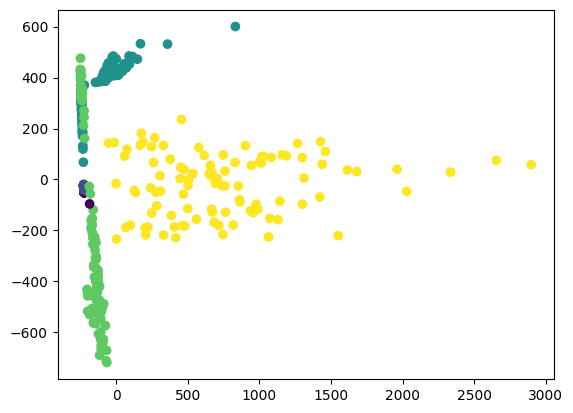

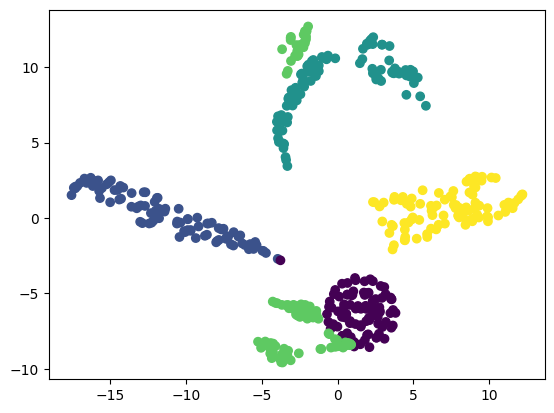

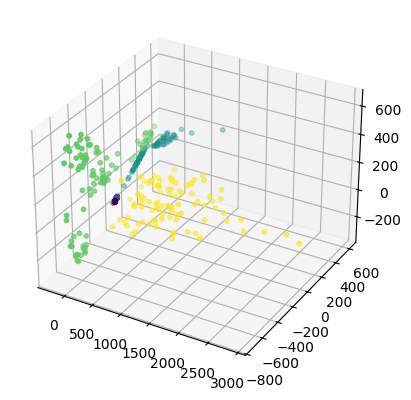

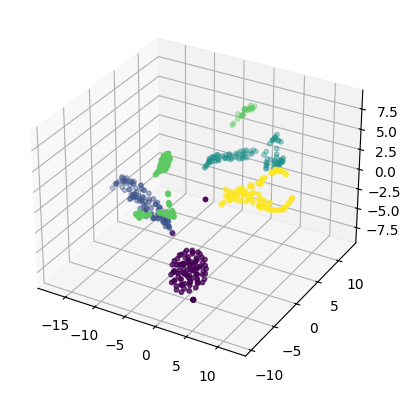

MovieWriter ffmpeg unavailable; using Pillow instead.


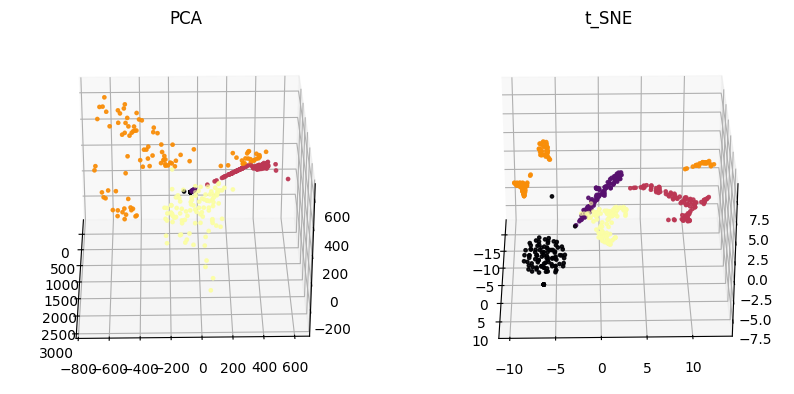

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from matplotlib import animation 
import seaborn as sns

pred = clf.predict(test_repr)
pca = PCA(n_components=3)
tsne = TSNE(n_components=3)
pca_comp = pca.fit_transform(test_repr)
tsne_comp = tsne.fit_transform(test_repr)

palette = sns.color_palette("bright", 10)

plt.scatter(pca_comp[:, 0], pca_comp[:, 1], c=pred)
plt.show()

plt.scatter(tsne_comp[:,0], tsne_comp[:,1], c=pred)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_comp[:, 0], pca_comp[:, 1], pca_comp[:, 2], c=pred, cmap='viridis', s=10)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_comp[:, 0], tsne_comp[:, 1], tsne_comp[:, 2], c=pred, cmap='viridis', s=10)
plt.show()



fig, axs = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={"projection":"3d"})

fontlabel = {"fontsize":"large", "color":"gray", "fontweight":"bold"}

def init():
    for ax, data in zip(axs, [pca_comp, tsne_comp]):
        title = "PCA" if ax == axs[0] else "t_SNE"
        ax.set_title(title) # , fontdict=fontlabel
        
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], 
                   c=pred, cmap="inferno", s=5, alpha=0.5)
    
    return fig,

def animate(i):
    axs[0].view_init(elev=30., azim=i)
    axs[1].view_init(elev=30., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('mpl3d_scatter.gif', fps=30)

----------------------------------------------------------------------
Accuracy | AUROC_i | AUROC_a | AUPRC_i | AUPRC_a |    f1_i |    f1_a |
  0.9960 |  0.9989 |  0.9994 |  0.9983 |  0.9989 |  0.9960 |  0.9960 |
Accuracy for classes
      0 |       1 |       2 |       3 |       4 |
  99.60 &   99.80 &   100.0 &   100.0 &   99.80 & 
F1 Score for classes
      0 |       1 |       2 |       3 |       4 |
 0.9901 &  0.9950 &  1.0000 &  1.0000 &  0.9950 & 


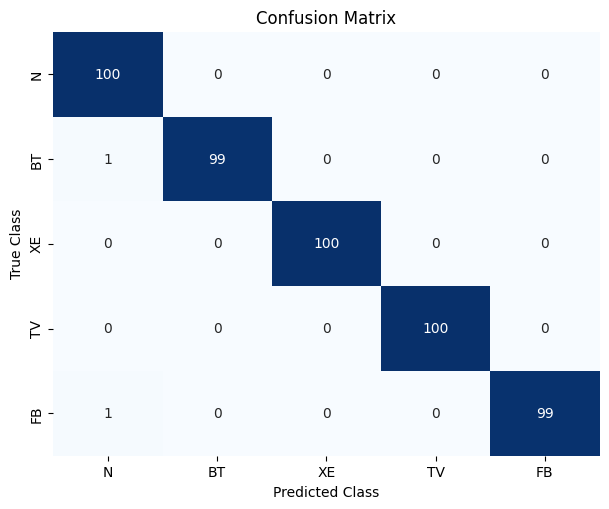

0.996 0.996 0.996


In [45]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import seaborn as sns

preds = clf.predict(test_repr)
targs = testset.data_y 

y_pred = out.argmax(1)
y_true = testset.data_y

correct = (y_pred == y_true).sum().item()
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['N', 'BT', 'XE', "TV", 'FB']
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
accuracy = acc
auroc_i = round(roc_auc_score(test_labels_onehot, y_score, average='micro'), 4)
auroc_a = round(roc_auc_score(test_labels_onehot, y_score, average='macro'), 4)
auprc_i = round(average_precision_score(test_labels_onehot, y_score, average='micro'), 4)
auprc_a = round(average_precision_score(test_labels_onehot, y_score, average='macro'), 4)
f1_a = round(f1_score(y_true, y_pred, average='macro'), 4)
f1_i = round(f1_score(y_true, y_pred, average='micro'), 4)
        
print('-'*70)
print('Accuracy | AUROC_i | AUROC_a | AUPRC_i | AUPRC_a |    f1_i |    f1_a |')
print(' ', format(accuracy, ".4f"), '| ', format(auroc_i, ".4f"), '| ', format(auroc_a, ".4f"), '| ', format(auprc_i, ".4f"), '| ', format(auprc_a, ".4f"), '| ', format(f1_i, ".4f"), '| ', format(f1_a, ".4f"), '|')
print('Accuracy for classes')
print('      0 |       1 |       2 |       3 |       4 |')
for i in range(args.class_num):
    print(' ', format(round(accuracy_score(test_labels_onehot[:,i], np.eye(5)[y_pred][:,i]), 4)*100, ".2f")[:5], end=' & ')
print()
print('F1 Score for classes')
print('      0 |       1 |       2 |       3 |       4 |')
for i in range(args.class_num):
    print('', format(round(f1_score(test_labels_onehot[:,i], np.eye(5)[y_pred][:,i]), 4), ".4f"), end=' & ')
print()

plt.figure(figsize=(6, 5))
sns.heatmap(dataframe, annot=True, cbar=None,cmap="Blues",fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()
print(accuracy, f1_i, f1_a)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_forecast_csv(name, univar=False):
    data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)
    dt_embed = _get_time_features(data.index)
    n_covariate_cols = dt_embed.shape[-1]
    
    if univar:
        if name in ('ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'):
            data = data[['OT']]
        elif name == 'electricity':
            data = data[['MT_001']]
        else:
            data = data.iloc[:, -1:]
        
    data = data.to_numpy()
    if name == 'ETTh1' or name == 'ETTh2':
        train_slice = slice(None, 12*30*24)
        valid_slice = slice(12*30*24, 16*30*24)
        test_slice = slice(16*30*24, 20*30*24)
    elif name == 'ETTm1' or name == 'ETTm2':
        train_slice = slice(None, 12*30*24*4)
        valid_slice = slice(12*30*24*4, 16*30*24*4)
        test_slice = slice(16*30*24*4, 20*30*24*4)
    else:
        train_slice = slice(None, int(0.6 * len(data)))
        valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
        test_slice = slice(int(0.8 * len(data)), None)
    
    scaler = StandardScaler().fit(data[train_slice])
    data = scaler.transform(data)
    if name in ('electricity'):
        data = np.expand_dims(data.T, -1)  # Each variable is an instance rather than a feature
    else:
        data = np.expand_dims(data, 0)
    
    if n_covariate_cols > 0:
        dt_scaler = StandardScaler().fit(dt_embed[train_slice])
        dt_embed = np.expand_dims(dt_scaler.transform(dt_embed), 0)
        data = np.concatenate([np.repeat(dt_embed, data.shape[0], axis=0), data], axis=-1)
    
    if name in ('ETTh1', 'ETTh2', 'electricity'):
        pred_lens = [24, 48, 168, 336, 720]
    else:
        pred_lens = [24, 48, 96, 288, 672]
        
    return data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols


def _get_time_features(dt):
    return np.stack([
        dt.minute.to_numpy(),
        dt.hour.to_numpy(),
        dt.dayofweek.to_numpy(),
        dt.day.to_numpy(),
        dt.dayofyear.to_numpy(),
        dt.month.to_numpy(),
        dt.weekofyear.to_numpy(),
    ], axis=1).astype(np.float)